## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

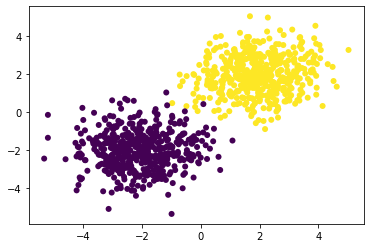

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

#net = Sequential()
#net.add(Linear(2, 4))
#net.add(ReLU())
#net.add(Linear(4, 2))
#net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

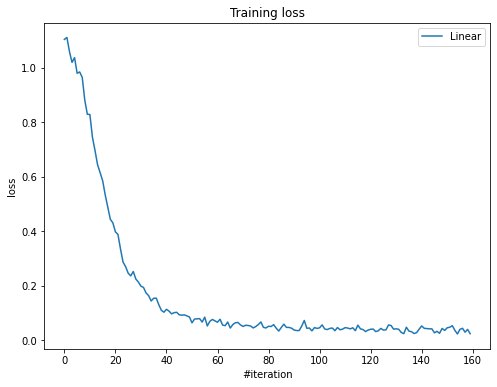

Current loss for Linear:0.024188


In [7]:
def TrainingLoss(X, Y, nets, optimizers, names, opt_configs):
    loss_history = []
    optimizer_state = []
    n = 0
    for i in enumerate(nets):
        optimizer_state.append({})
        loss_history.append([])
        n += 1
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):
            for net in nets:
                net.zeroGradParameters()
        
        # Forward
            predictions = []
            losses = []
            for i in range(0, n):
                predictions.append(nets[i].forward(x_batch))
                losses.append(criterion.forward(predictions[i], y_batch))
    
        # Backward
            dp = []
            for i in range(0, n):
                dp.append(criterion.backward(predictions[i], y_batch))
                nets[i].backward(x_batch, dp[i])
        
        # Update weights
            for i in range(0, n):
                optimizers[i](nets[i].getParameters(), 
                             nets[i].getGradParameters(), 
                             opt_configs[i],
                             optimizer_state[i])      
                loss_history[i].append(losses[i])

    # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        for i in range(0,n):
            plt.plot(loss_history[i], label=names[i])
        plt.legend()
        plt.show()
    
        for i in range(0,n):
            print('Current loss for %s:' %names[i] + '%f' % losses[i])   
        
TrainingLoss(X, Y, [net], [sgd_momentum], ['Linear'], [{'learning_rate' : 1e-3, 'momentum': 0.95}])

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()
print(X_train.shape)

(50000, 28, 28)


One-hot encode the labels first.

In [9]:
print(X_train.shape[0])

50000


In [10]:
from sklearn.preprocessing import OneHotEncoder

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)

OHE = OneHotEncoder(sparse=False)
y_train = OHE.fit_transform(y_train.reshape(-1, 1))
y_val = OHE.fit_transform(y_val.reshape(-1, 1))
y_test = OHE.fit_transform(y_test.reshape(-1, 1))

(50000, 784)


/home/peter/p/tf-demo/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/peter/p/tf-demo/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/peter/p/tf-demo/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [11]:
relu_net = Sequential()
relu_net.add(Linear(784, 150))
relu_net.add(ReLU())
relu_net.add(Linear(150, 10))
relu_net.add(LogSoftMax())

elu_net = Sequential()
elu_net.add(Linear(784, 150))
elu_net.add(ELU())
elu_net.add(Linear(150, 10))
elu_net.add(LogSoftMax())

lrelu_net = Sequential()
lrelu_net.add(Linear(784, 150))
lrelu_net.add(LeakyReLU())
lrelu_net.add(Linear(150, 10))
lrelu_net.add(LogSoftMax())

softp_net = Sequential()
softp_net.add(Linear(784, 150))
softp_net.add(SoftPlus())
softp_net.add(Linear(150, 10))
softp_net.add(LogSoftMax())

bn_relu_net = Sequential()
bn_relu_net.add(Linear(784, 150))
bn_relu_net.add(ReLU())
bn_relu_net.add(BatchNormalization(0.9))
bn_relu_net.add(ChannelwiseScaling(150))
bn_relu_net.add(Linear(150, 10))
bn_relu_net.add(LogSoftMax())

bn_elu_net = Sequential()
bn_elu_net.add(Linear(784, 150))
bn_elu_net.add(ELU())
bn_elu_net.add(BatchNormalization(0.9))
bn_elu_net.add(ChannelwiseScaling(150))
bn_elu_net.add(Linear(150, 10))
bn_elu_net.add(LogSoftMax())

bn_lrelu_net = Sequential()
bn_lrelu_net.add(Linear(784, 150))
bn_lrelu_net.add(LeakyReLU())
bn_lrelu_net.add(BatchNormalization(0.9))
bn_lrelu_net.add(ChannelwiseScaling(150))
bn_lrelu_net.add(Linear(150, 10))
bn_lrelu_net.add(LogSoftMax())

bn_softp_net = Sequential()
bn_softp_net.add(Linear(784, 150))
bn_softp_net.add(SoftPlus())
bn_softp_net.add(BatchNormalization(0.5))
bn_softp_net.add(ChannelwiseScaling(150))
bn_softp_net.add(Linear(150, 10))
bn_softp_net.add(LogSoftMax())

adam_bn_relu_net = Sequential()
adam_bn_relu_net.add(Linear(784, 150))
adam_bn_relu_net.add(ReLU())
adam_bn_relu_net.add(BatchNormalization(0.9))
adam_bn_relu_net.add(ChannelwiseScaling(150))
adam_bn_relu_net.add(Linear(150, 10))
adam_bn_relu_net.add(LogSoftMax())

sgd_bn_relu_net = Sequential()
sgd_bn_relu_net.add(Linear(784, 150))
sgd_bn_relu_net.add(ReLU())
sgd_bn_relu_net.add(BatchNormalization(0.9))
sgd_bn_relu_net.add(ChannelwiseScaling(150))
sgd_bn_relu_net.add(Linear(150, 10))
sgd_bn_relu_net.add(LogSoftMax())

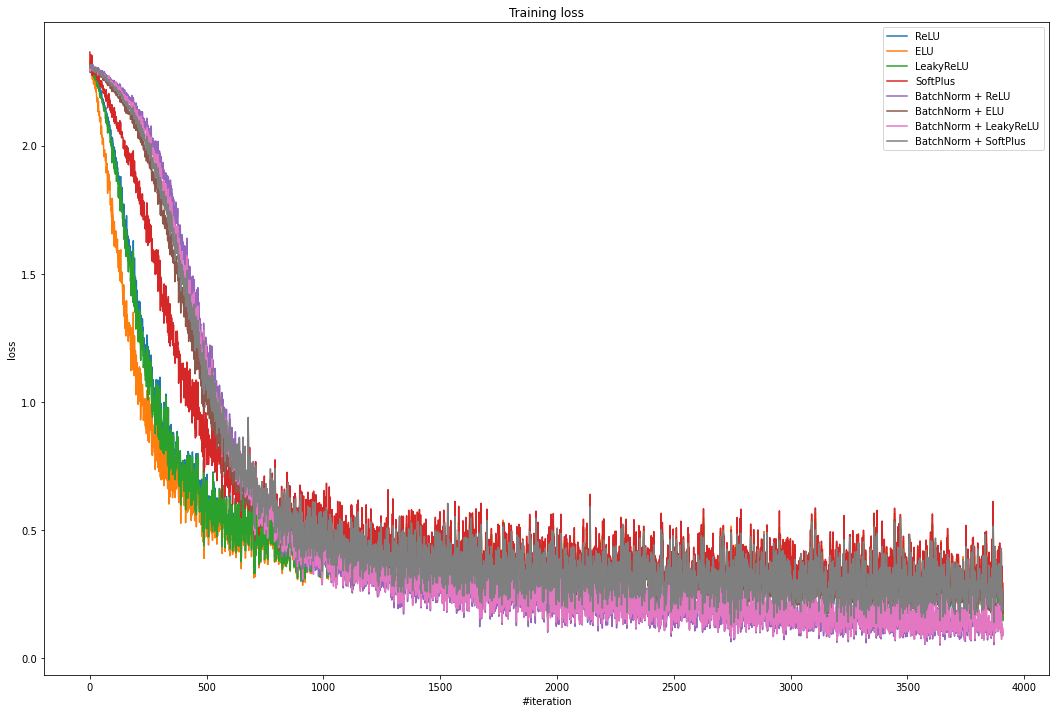

Current loss for ReLU:0.151308
Current loss for ELU:0.160630
Current loss for LeakyReLU:0.147220
Current loss for SoftPlus:0.176044
Current loss for BatchNorm + ReLU:0.097600
Current loss for BatchNorm + ELU:0.177964
Current loss for BatchNorm + LeakyReLU:0.117013
Current loss for BatchNorm + SoftPlus:0.189496


In [12]:
loss_history = [[], [], [], [], [], [], [], []]

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.95}
n_epoch = 10

optimizer_state = [{}, {}, {}, {}, {}, {}, {}, {}]
nets = [relu_net, elu_net, lrelu_net, softp_net, bn_relu_net, bn_elu_net, bn_lrelu_net, bn_softp_net]
names = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus', 'BatchNorm + ReLU', 'BatchNorm + ELU', 'BatchNorm + LeakyReLU', 'BatchNorm + SoftPlus']

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        for net in nets:
            net.zeroGradParameters()
        
        # Forward
        predictions = []
        losses = []
        for i in range(0,8):
            predictions.append(nets[i].forward(x_batch))
            losses.append(criterion.forward(predictions[i], y_batch))
    
        # Backward
        dp = []
        for i in range(0,8):
            dp.append(criterion.backward(predictions[i], y_batch))
        
        
        for i, net in enumerate(nets, 0):
            net.backward(x_batch, dp[i])
        
        # Update weights
        for i, net in enumerate(nets, 0):
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state[i])
        
            loss_history[i].append(losses[i])

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(18, 12))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    for i in range(0,8):
        plt.plot(loss_history[i], label=names[i])
    plt.legend()
    plt.show()
    
    for i in range(0,8):
        print('Current loss for %s:' %names[i] + '%f' % losses[i])    

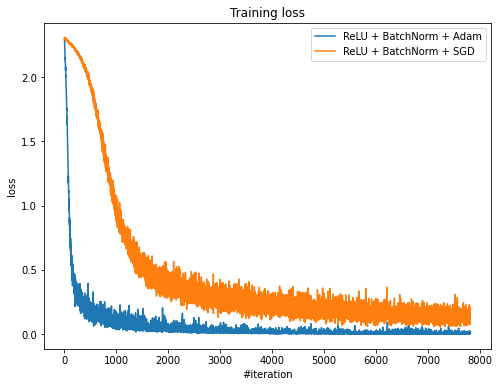

Current loss for ReLU + BatchNorm + Adam:0.002941
Current loss for ReLU + BatchNorm + SGD:0.187264


In [13]:
n_epoch = 20
TrainingLoss(X_train, y_train, [adam_bn_relu_net, sgd_bn_relu_net], [adam_optimizer, sgd_momentum], ['ReLU + BatchNorm + Adam', 'ReLU + BatchNorm + SGD'], [{'learning_rate' : 1e-3, 'beta1': 0.9, 'beta2' : 0.999, 'epsilon' : 1e-8}, {'learning_rate' : 1e-3, 'momentum': 0.9}])

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

BatchNormalization decreases loss, but it is also decreases speed of training as it seen on the plot above. SoftPlus gives worst results from all considered activation functions. ReLU, ELU and LeakyReLU work better. On the 1st plot lines are distinguishable up to approximately 600 iterations. Adam works faster and gives lower loss than SGD.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [17]:
best_net = Sequential()
best_net.add(Linear(784, 150))
best_net.add(ELU())
best_net.add(BatchNormalization(0.9))
best_net.add(ChannelwiseScaling(150))
best_net.add(Dropout(0.5))
best_net.add(Linear(150, 10))
best_net.add(LogSoftMax())

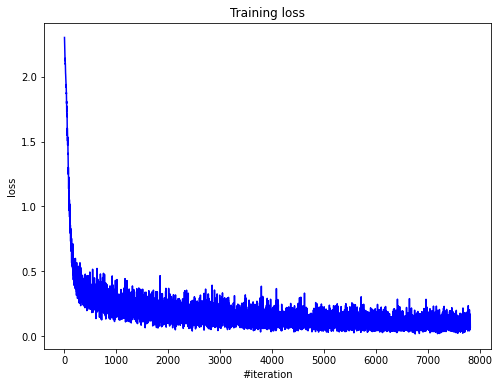

Current loss: 0.067648


In [18]:
from sklearn.metrics import accuracy_score

loss_history = []
accuracy_scores = []
n_epoch = 20
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.9, 'beta2' : 0.999, 'epsilon' : 1e-8}
optimizer_state = {}

for i in range(n_epoch):
    
    best_net.train()
    
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        best_net.zeroGradParameters()
        
        # Forward
        predictions = best_net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        best_net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(best_net.getParameters(), 
                     best_net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        
    best_net.evaluate()

    accuracy_scores.append(accuracy_score(best_net.forward(X_val).argmax(axis=1), y_val.argmax(axis=1)))
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

Print here your accuracy on test set. It should be around 90%.

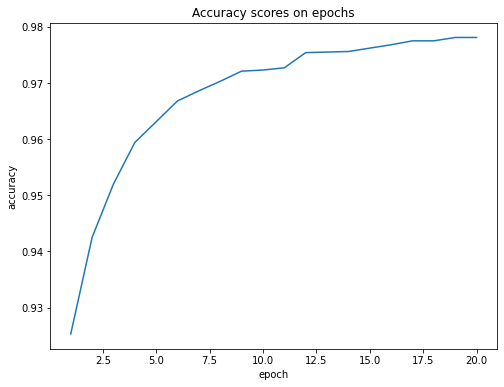

accuracy:  0.9762


In [19]:
plt.figure(figsize=(8, 6))
        
plt.title("Accuracy scores on epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(np.arange(1, 21, 1), accuracy_scores)
plt.show()

print('accuracy: ', accuracy_score(best_net.forward(X_test).argmax(axis=1), y_test.argmax(axis=1)))

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

copied_net = nn.Sequential(
    nn.Linear(784, 150),
    nn.ELU(),
    nn.BatchNorm1d(150, eps = 1e-3, momentum=0.9),
    nn.Dropout(p=0.5),
    nn.Linear(150, 10),
    nn.LogSoftmax(-1),
)

adam = optim.Adam(copied_net.parameters())
criterion = nn.CrossEntropyLoss()

X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

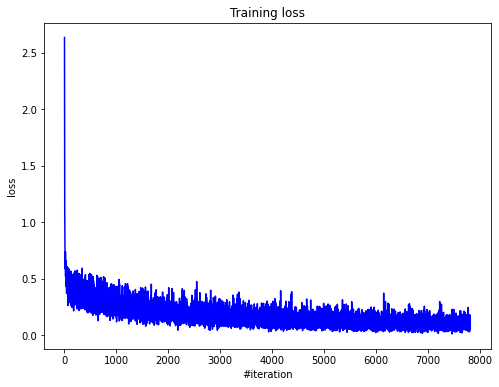

Current loss: 0.120747


In [21]:
loss_history = []
accuracy_scores = []
n_epoch = 20

for i in range(n_epoch):
    
    copied_net.train()
    
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        copied_net.zero_grad()
            
        # Forward
        predictions = copied_net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        # Backward
        loss.backward()
            
        # Update weights
        adam.step()     
            
        loss_history.append(loss.detach().numpy())

    copied_net.eval()
    accuracy_scores.append(accuracy_score(copied_net.forward(X_val).argmax(axis=1), y_val.argmax(axis=1)))

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
           
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    print('Current loss: %f' % loss) 

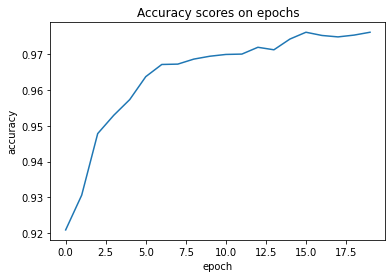

accuracy:  0.9741


In [22]:
plt.plot(np.array(range(0, 20, 1)), accuracy_scores)
plt.title("Accuracy scores on epochs")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

print('accuracy: ', accuracy_score(copied_net.forward(X_test).argmax(axis=1), y_test.argmax(axis=1)))